1. **Combines a pretrained Densenet169 Model with the Final Layer trained seperately.**

2. **Final Layer weights are loaded into the model and then entire model is trained.**


## Get Data

In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d jackstapleton/petfinder-pretrained-images-nocrop

!mkdir ~/.data
!unzip -q petfinder-pretrained-images-nocrop.zip -d /.data

clear_output()

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

clear_output()

## Library Imports

In [3]:
import os
import re
import gc
import pickle
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import models, transforms

from time import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

## Constants and Utilities

In [4]:
SEED = 49
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_FEATURES = 1664
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225]),
                                ])

IMAGE_PATH = "/.data"
STATE_PATH = "/content/gdrive/My Drive/Temp"

verbose = True
DEBUG = False

sc_y = StandardScaler()

In [5]:
def breaker(num=50, char="*") -> None:
    print("\n" + num*char + "\n")


def get_targets() -> np.ndarray:
    df = pd.read_csv("/content/gdrive/My Drive/train.csv", engine="python")
    targets = df["Pawpularity"].copy().values
    return targets.reshape(-1, 1)


def show_graphs(L: list, title=None) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(L) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="train")
    plt.plot(x_Axis, VL, "b", label="valid")
    plt.grid()
    plt.legend()
    if title:
        plt.title("{} Loss".format(title))
    else:
        plt.title("Loss")
    plt.show()

## Dataset Template and Build Dataloader

In [6]:
class DS(Dataset):
    def __init__(self, images=None, targets=None, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        return self.transform(self.images[idx]), torch.FloatTensor(self.targets[idx])


def build_dataloaders(tr_images: np.ndarray, va_images: np.ndarray,
                              tr_targets: np.ndarray, va_targets: np.ndarray,
                              batch_size: int, seed: int, transform=None):

    if verbose:
        breaker()
        print("Building Train and Validation DataLoaders ...")
    
    tr_data_setup = DS(images=tr_images, targets=tr_targets, transform=transform)
    va_data_setup = DS(images=va_images, targets=va_targets, transform=transform)
    
    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(seed)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
    }
    
    return dataloaders

## Build Model

In [7]:
def build_model(IL: int, seed: int, path: str):
    class Model(nn.Module):
        def __init__(self, IL=None):
            super(Model, self).__init__()

            self.features = models.densenet169(pretrained=True, progress=False)
            self.features = nn.Sequential(*[*self.features.children()][:-1])
            self.features.add_module("Adaptive Average Pool", nn.AdaptiveAvgPool2d(output_size=(1, 1)))
            self.features.add_module("Flatten", nn.Flatten())

            self.predictor = nn.Sequential()
            self.predictor.add_module("BN", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            self.predictor.add_module("FC", WN(nn.Linear(in_features=IL, out_features=1)))
        
        def get_optimizer(self, lr=1e-3, wd=0.0):
            params = [p for p in self.parameters() if p.requires_grad]
            return optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
        
        def forward(self, x1, x2=None):
            if x2 is not None:
                x1 = self.features(x1)
                x2 = self.features(x2)
                return self.predictor(x1), self.predictor(x2)
            else:
                x1 = self.features(x1)
                return self.predictor(x1)

    
    model = Model(IL=IL)
    
    pretrained_state_dict = torch.load(path, map_location=DEVICE)["model_state_dict"]
    model.predictor.BN.weight = nn.Parameter(pretrained_state_dict["predictor.BN.weight"])
    model.predictor.BN.bias = nn.Parameter(pretrained_state_dict["predictor.BN.bias"]) 
    model.predictor.FC.bias = nn.Parameter(pretrained_state_dict["predictor.FC.bias"])
    model.predictor.FC.weight_g = nn.Parameter(pretrained_state_dict["predictor.FC.weight_g"]) 
    model.predictor.FC.weight_v = nn.Parameter(pretrained_state_dict["predictor.FC.weight_v"]) 

    return model

## Fit and Predict

In [8]:
def fit(model=None, optimizer=None, scheduler=None, 
        epochs=None, early_stopping_patience=None,
        dataloaders=None, verbose=False) -> tuple:
    
    name = "./state.pt"

    breaker()
    print("Training ...")
    breaker()

    Losses = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : np.inf, "valid" : np.inf}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.MSELoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           name)
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    if verbose:
                        print("\nEarly Stopping at Epoch {}".format(e))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict": model.state_dict(),
                        "optim_state_dict": optimizer.state_dict()},
                       name)
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
    
    if verbose:
        breaker()
        print("Best Validation Loss at Epoch {}".format(BLE))
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
        breaker()
        print("Training Completed")
        breaker()

    return Losses, BLE, name

#####################################################################################################

def predict_batch(model=None, dataloader=None, mode="test", path=None) -> np.ndarray:    
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    y_pred = torch.zeros(1, 1).to(DEVICE)
    if re.match(r"valid", mode, re.IGNORECASE):
        for X, _ in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    elif re.match(r"test", mode, re.IGNORECASE):
        for X in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

# Train

In [9]:
def train(images: np.ndarray, targets: np.ndarray, n_splits: int, 
          batch_size: int, lr: float, wd: float, 
          epochs: int, early_stopping: int, path: str,
          patience=None, eps=None) -> list:        
        
    fold = 1
    for tr_idx, va_idx in KFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(images):
        fold += 1
        if fold == 8:
            break
        
    tr_images, va_images   = images[tr_idx], images[va_idx]
    tr_targets, va_targets = targets[tr_idx], targets[va_idx]

    tr_targets = sc_y.fit_transform(tr_targets)
    va_targets = sc_y.transform(va_targets)

    dataloaders = build_dataloaders(tr_images, va_images, 
                                    tr_targets, va_targets, 
                                    batch_size, SEED, 
                                    transform=TRANSFORM)
    model = build_model(IL=NUM_FEATURES, seed=SEED, path=path).to(DEVICE)
    optimizer = model.get_optimizer(lr=lr, wd=wd)
    scheduler = None
    if isinstance(patience, int) and isinstance(eps, float):
        scheduler = model.get_plateau_scheduler(optimizer, patience, eps)

    L, _, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                     epochs=epochs, early_stopping_patience=early_stopping,
                     dataloaders=dataloaders, verbose=verbose)
    y_pred = predict_batch(model=model, dataloader=dataloaders["valid"], mode="valid", path=name)
    RMSE = np.sqrt(mean_squared_error(sc_y.inverse_transform(y_pred), sc_y.inverse_transform(va_targets)))
    if verbose:
        print("Validation RMSE : {:.5f}".format(RMSE))
        breaker()
        show_graphs(L)

## Main

In [10]:
def main():
    breaker()
    print("Clean Memory , {} Objects Collected ...".format(gc.collect()))

    ########### Params ###########
    
    if DEBUG:
        n_splits = 3
        patience, eps = 5, 1e-8
        epochs, early_stopping = 5, 5

        batch_size = 64
        lr = 1e-5
        wd = 1e-5
    else:
        n_splits = 10
        patience, eps = 5, 1e-8
        epochs, early_stopping = 25, 8

        batch_size = 64
        lr = 1e-5
        wd = 1e-5
    
    ##############################

    if verbose:
        breaker()
        print("Loading Data ...")
    
    images = np.load(os.path.join(IMAGE_PATH, "Images_224x224.npy"))
    targets  = get_targets()
    pretrained_ann_path = os.path.join(STATE_PATH, "Fold_8_state.pt")

    # Without Scheduler
    train(images, targets, n_splits, batch_size, lr, wd, epochs, early_stopping, pretrained_ann_path, patience=None, eps=None)

    # With Scheduler
    # train(images, targets, n_splits, batch_size, lr, wd, epochs, early_stopping, pretrained_ann_path, patience=patience, eps=eps)
    breaker()


**************************************************

Clean Memory , 584 Objects Collected ...

**************************************************

Loading Data ...

**************************************************

Building Train and Validation DataLoaders ...


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth



**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 0.78886 | Valid Loss: 0.84806 | Time: 243.94 seconds
Epoch: 2 | Train Loss: 0.78808 | Valid Loss: 0.84557 | Time: 243.31 seconds
Epoch: 3 | Train Loss: 0.78363 | Valid Loss: 0.84388 | Time: 243.33 seconds
Epoch: 4 | Train Loss: 0.77724 | Valid Loss: 0.84045 | Time: 243.12 seconds
Epoch: 5 | Train Loss: 0.77442 | Valid Loss: 0.84198 | Time: 242.76 seconds
Epoch: 6 | Train Loss: 0.76768 | Valid Loss: 0.83971 | Time: 243.03 seconds
Epoch: 7 | Train Loss: 0.76894 | Valid Loss: 0.84271 | Time: 242.62 seconds
Epoch: 8 | Train Loss: 0.76223 | Valid Loss: 0.84084 | Time: 242.63 seconds
Epoch: 9 | Train Loss: 0.76335 | Valid Loss: 0.84085 | Time: 242.65 seconds
Epoch: 10 | Train Loss: 0.75770 | Valid Loss: 0.83964 | Time: 243.04 seconds
Epoch: 11 | Train Loss: 0.75382 | Valid Loss: 0.83749 | Time: 243.33 seconds
Epoch: 12 | Train Loss: 0.75295 | Valid Los

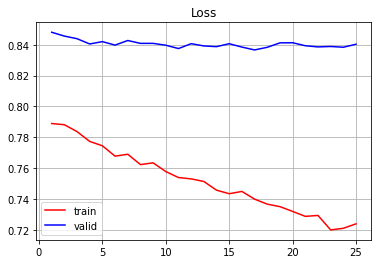


**************************************************



In [11]:
main()